In [98]:
# Data management
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Graphics
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

# Preprocessing and modelling
# ------------------------------------------------------------------------------
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn import set_config
import multiprocessing

from sklearn.metrics import accuracy_score
from sklearn import metrics 


# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
#warnings.filterwarnings('once')
warnings.filterwarnings('ignore')

In [99]:
# Data Loading


#training data
data_train = pd.read_csv('https://raw.githubusercontent.com/SantiagoArenas/MachineLearning/main/austinHousingData.csv')
data_train.head()



,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,...,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage
0,111373431,pflugerville,14424 Lake Victor Dr,78660,"14424 Lake Victor Dr, Pflugerville, TX 78660 i...",30.430632,-97.663078,1.98,2,True,...,1,1,1.266667,2.666667,1063,14,3.0,4,2,111373431_ffce26843283d3365c11d81b8e6bdc6f-p_f...
1,120900430,pflugerville,1104 Strickling Dr,78660,Absolutely GORGEOUS 4 Bedroom home with 2 full...,30.432673,-97.661697,1.98,2,True,...,1,1,1.400000,2.666667,1063,14,2.0,4,1,120900430_8255c127be8dcf0a1a18b7563d987088-p_f...
2,2084491383,pflugerville,1408 Fort Dessau Rd,78660,Under construction - estimated completion in A...,30.409748,-97.639771,1.98,0,True,...,1,1,1.200000,3.000000,1108,14,2.0,3,1,2084491383_a2ad649e1a7a098111dcea084a11c855-p_...
3,120901374,pflugerville,1025 Strickling Dr,78660,Absolutely darling one story home in charming ...,30.432112,-97.661659,1.98,2,True,...,1,1,1.400000,2.666667,1063,14,2.0,3,1,120901374_b469367a619da85b1f5ceb69b675d88e-p_f...
4,60134862,pflugerville,15005 Donna Jane Loop,78660,Brimming with appeal & warm livability! Sleek ...,30.437368,-97.656860,1.98,0,True,...,1,1,1.133333,4.000000,1223,14,3.0,3,2,60134862_b1a48a3df3f111e005bb913873e98ce2-p_f.jpg


In [100]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15171 entries, 0 to 15170
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   zpid                        15171 non-null  int64  
 1   city                        15171 non-null  object 
 2   streetAddress               15171 non-null  object 
 3   zipcode                     15171 non-null  int64  
 4   description                 15171 non-null  object 
 5   latitude                    15171 non-null  float64
 6   longitude                   15171 non-null  float64
 7   propertyTaxRate             15171 non-null  float64
 8   garageSpaces                15171 non-null  int64  
 9   hasAssociation              15171 non-null  bool   
 10  hasCooling                  15171 non-null  bool   
 11  hasGarage                   15171 non-null  bool   
 12  hasHeating                  15171 non-null  bool   
 13  hasSpa                      151

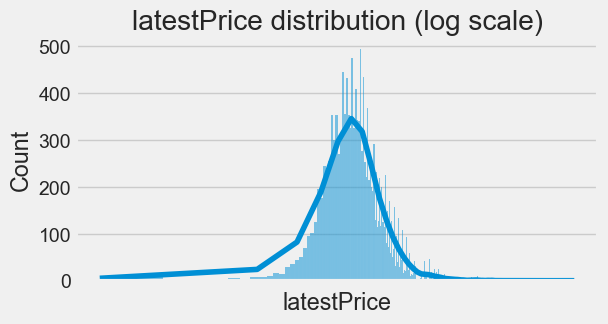

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data_train' is your DataFrame
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))

# Determine bin edges
bin_edges = list(range(int(data_train['latestPrice'].min()), int(data_train['latestPrice'].max()) + 10001, 10000))

# Plot the histogram with grouped bins
sns.histplot(data=data_train, x='latestPrice', kde=True, bins=bin_edges, ax=ax)
ax.set_xscale('log')
ax.set_title("latestPrice distribution (log scale)")
ax.set_xlabel('latestPrice')
ax.set_xticks([])
plt.show()


Text(0.5, 0, 'latestPrice')

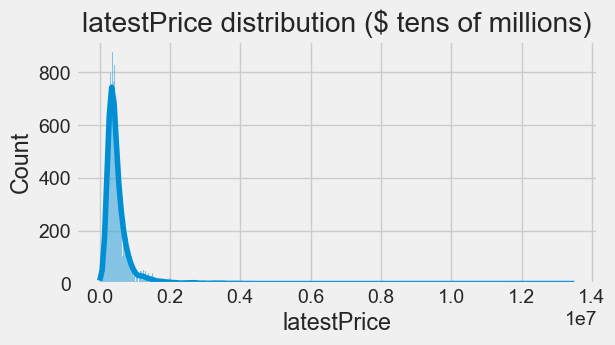

In [102]:
# Distribution of the output variable
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
sns.histplot(data=data_train, x='latestPrice', kde=True,ax=ax)
ax.set_title("latestPrice distribution ($ tens of millions)")
ax.set_xlabel('latestPrice')

In [103]:
# Columnas descartables de inicio
data_train = data_train.drop(["description","homeImage","zpid","streetAddress","latest_saledate","latestPriceSource", 'garageSpaces'], axis=1)
#Cogemos los datos que queremos
data_train = data_train[data_train['city'] == 'austin']
data_train = data_train[data_train['homeType'] == 'Single Family']
#Tiene los mismos valores siempre, entonces no aporta nada
data_train = data_train.drop(["city","homeType"], axis=1)

In [104]:
numeric_cols = data_train.select_dtypes(include=['float64', 'int64']).columns.to_list()
cat_cols = data_train.select_dtypes(include=['object', 'category', 'bool']).columns.to_list()

In [105]:
#Prefijos para las dummies
new_column_names = [
    'Dmy_association',
    'Dmy_cooling',
    'Dmy_garage',
    'Dmy_heating',
    'Dmy_spa',
    'Dmy_view'
]
data=pd.get_dummies(data_train, columns=cat_cols, prefix=new_column_names,drop_first=True, dtype= 'int64' ) 
print(data.dtypes)

zipcode                         int64
latitude                      float64
longitude                     float64
propertyTaxRate               float64
parkingSpaces                   int64
yearBuilt                       int64
latestPrice                   float64
numPriceChanges                 int64
latest_salemonth                int64
latest_saleyear                 int64
numOfPhotos                     int64
numOfAccessibilityFeatures      int64
numOfAppliances                 int64
numOfParkingFeatures            int64
numOfPatioAndPorchFeatures      int64
numOfSecurityFeatures           int64
numOfWaterfrontFeatures         int64
numOfWindowFeatures             int64
numOfCommunityFeatures          int64
lotSizeSqFt                   float64
livingAreaSqFt                float64
numOfPrimarySchools             int64
numOfElementarySchools          int64
numOfMiddleSchools              int64
numOfHighSchools                int64
avgSchoolDistance             float64
avgSchoolRat

In [106]:
# Configuring train and test datasets
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                                        data.drop(columns = "latestPrice"),
                                        data['latestPrice'],
                                        random_state = 123,
                                        test_size=0.2
                                    )


In [107]:
# Checking quality of training and test datasets

print("Training dataset")
print("-----------------------")
display(y_train.describe())
display(X_train.describe())
#display(X_train.describe(include = 'object'))
print(" ")

print("Test dataset")
print("-----------------------")
display(y_test.describe())
display(X_test.describe())
#display(X_test.describe(include = 'object'))

Training dataset
-----------------------


count    1.127600e+04
mean     5.178892e+05
std      4.607693e+05
min      5.500000e+03
25%      3.100000e+05
50%      4.100000e+05
75%      5.750000e+05
max      1.350000e+07
Name: latestPrice, dtype: float64

,zipcode,latitude,longitude,propertyTaxRate,parkingSpaces,yearBuilt,numPriceChanges,latest_salemonth,latest_saleyear,numOfPhotos,...,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,Dmy_association_True,Dmy_cooling_True,Dmy_garage_True,Dmy_heating_True,Dmy_spa_True,Dmy_view_True
count,11276.000000,11276.000000,11276.000000,11276.000000,11276.000000,11276.000000,11276.000000,11276.000000,11276.000000,11276.000000,...,11276.000000,11276.000000,11276.000000,11276.000000,11276.000000,11276.000000,11276.00000,11276.000000,11276.000000,11276.000000
mean,78737.180294,30.291704,-97.781258,1.994800,1.236343,1988.109702,3.040617,6.707520,2019.076712,30.708762,...,14.870167,2.696031,3.477297,1.455126,0.512327,0.984569,0.55055,0.991752,0.080170,0.224636
std,15.524967,0.098111,0.085466,0.054279,1.344551,21.624732,2.493689,3.142519,0.814429,20.965425,...,1.756885,1.039642,0.784506,0.518252,0.499870,0.123265,0.49746,0.090445,0.271569,0.417361
min,78652.000000,30.103020,-98.020477,1.980000,0.000000,1905.000000,1.000000,1.000000,2018.000000,1.000000,...,10.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,78727.000000,30.201029,-97.842182,1.980000,0.000000,1974.000000,1.000000,4.000000,2018.000000,20.000000,...,14.000000,2.000000,3.000000,1.000000,0.000000,1.000000,0.00000,1.000000,0.000000,0.000000
50%,78739.000000,30.284507,-97.772038,1.980000,1.000000,1993.000000,2.000000,7.000000,2019.000000,29.000000,...,15.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.00000,1.000000,0.000000,0.000000
75%,78749.000000,30.367307,-97.719809,1.980000,2.000000,2006.000000,4.000000,9.000000,2020.000000,39.000000,...,16.000000,3.000000,4.000000,2.000000,1.000000,1.000000,1.00000,1.000000,0.000000,0.000000
max,78759.000000,30.517174,-97.569504,2.210000,20.000000,2020.000000,23.000000,12.000000,2021.000000,179.000000,...,19.000000,27.000000,8.000000,4.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


 
Test dataset
-----------------------


count    2.820000e+03
mean     5.210458e+05
std      3.934615e+05
min      6.000000e+03
25%      3.150000e+05
50%      4.127500e+05
75%      5.941250e+05
max      5.474997e+06
Name: latestPrice, dtype: float64

,zipcode,latitude,longitude,propertyTaxRate,parkingSpaces,yearBuilt,numPriceChanges,latest_salemonth,latest_saleyear,numOfPhotos,...,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,Dmy_association_True,Dmy_cooling_True,Dmy_garage_True,Dmy_heating_True,Dmy_spa_True,Dmy_view_True
count,2820.000000,2820.000000,2820.000000,2820.000000,2820.000000,2820.000000,2820.000000,2820.000000,2820.000000,2820.000000,...,2820.000000,2820.000000,2820.000000,2820.000000,2820.000000,2820.000000,2820.000000,2820.000000,2820.000000,2820.000000
mean,78737.312766,30.295035,-97.781943,1.995046,1.247163,1988.519149,3.098227,6.799645,2019.074468,31.779078,...,14.937589,2.731028,3.490071,1.469149,0.512766,0.983688,0.554255,0.992553,0.088298,0.228369
std,15.385713,0.097625,0.083087,0.055209,1.345143,21.219323,2.508997,3.112403,0.804466,22.237849,...,1.748563,1.023965,0.768464,0.512461,0.499926,0.126695,0.497136,0.085988,0.283778,0.419856
min,78702.000000,30.085030,-98.022057,1.980000,0.000000,1906.000000,1.000000,1.000000,2018.000000,1.000000,...,10.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,78728.000000,30.205616,-97.842207,1.980000,0.000000,1975.000000,1.000000,4.000000,2018.000000,21.000000,...,14.000000,2.000000,3.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,78739.000000,30.289112,-97.776329,1.980000,1.000000,1993.000000,2.000000,7.000000,2019.000000,30.000000,...,15.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
75%,78749.000000,30.370327,-97.721018,1.980000,2.000000,2005.000000,4.000000,9.000000,2020.000000,39.000000,...,16.000000,3.000000,4.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,78759.000000,30.513062,-97.570633,2.210000,12.000000,2020.000000,19.000000,12.000000,2021.000000,175.000000,...,19.000000,10.000000,7.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [108]:
# Taking care of variables according to their type  OPTION 1
# ==============================================================================
# The numerical columns are standardized (normaliozed) 
# The categorical columns are treated using one-hot-encoding
# To keep the columns that we do not want to apply any transformation
# we have to apply remainder='passthrough'.

# Identificaction of numerivcal and categorical columns
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.to_list()

# Transformations for the numerical variables
numeric_transformer = Pipeline(
                        #steps=[('scaler', StandardScaler())]
                        steps=[('scaler', MinMaxScaler())]
                      )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols)
                    ],
                    remainder='passthrough'
                )

In [109]:
numeric_cols

['zipcode',
 'latitude',
 'longitude',
 'propertyTaxRate',
 'parkingSpaces',
 'yearBuilt',
 'numPriceChanges',
 'latest_salemonth',
 'latest_saleyear',
 'numOfPhotos',
 'numOfAccessibilityFeatures',
 'numOfAppliances',
 'numOfParkingFeatures',
 'numOfPatioAndPorchFeatures',
 'numOfSecurityFeatures',
 'numOfWaterfrontFeatures',
 'numOfWindowFeatures',
 'numOfCommunityFeatures',
 'lotSizeSqFt',
 'livingAreaSqFt',
 'numOfPrimarySchools',
 'numOfElementarySchools',
 'numOfMiddleSchools',
 'numOfHighSchools',
 'avgSchoolDistance',
 'avgSchoolRating',
 'avgSchoolSize',
 'MedianStudentsPerTeacher',
 'numOfBathrooms',
 'numOfBedrooms',
 'numOfStories',
 'Dmy_association_True',
 'Dmy_cooling_True',
 'Dmy_garage_True',
 'Dmy_heating_True',
 'Dmy_spa_True',
 'Dmy_view_True']

In [110]:
set_config(display='diagram')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['zipcode', 'latitude', 'longitude',
                                  'propertyTaxRate', 'parkingSpaces',
                                  'yearBuilt', 'numPriceChanges',
                                  'latest_salemonth', 'latest_saleyear',
                                  'numOfPhotos', 'numOfAccessibilityFeatures',
                                  'numOfAppliances', 'numOfParkingFeatures',
                                  'numOfPatioAndPorchFeatures',
                                  'numOfSecurityFeatures',
                                  'numOfWaterfrontFeatures',
                                  'numOfWindowFeatures',
                                  'numOfCommunityFeatures', 'lotSizeSqFt',
                                  'livingAreaSqFt', 'numOfPrimarySchools',
                                  'numOfElementarySchools',
                                  'numOfMiddleSchools', 'numOfHighSchools',
                                  'avgSchoolDistance', 'avgSchoolRating',
                                  'avgSchoolSize', 'MedianStudentsPerTeacher',
                                  'numOfBathrooms', 'numOfBedrooms', ...])])

In [111]:
set_config(display='text')

In [112]:
# Application of transformations   ----- OUTPUTs are not normalized
# ==============================================================================
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

In [113]:
X_train_prep

array([[0.90654206, 0.25859369, 0.36491287, ..., 1.        , 0.        ,
        0.        ],
       [0.77570093, 0.35366314, 0.32869227, ..., 1.        , 0.        ,
        1.        ],
       [0.71028037, 0.82088645, 0.74170191, ..., 1.        , 0.        ,
        1.        ],
       ...,
       [0.91588785, 0.79602645, 0.47428523, ..., 1.        , 0.        ,
        0.        ],
       [0.78504673, 0.32201938, 0.29879885, ..., 1.        , 0.        ,
        1.        ],
       [0.71028037, 0.82622872, 0.75093893, ..., 1.        , 1.        ,
        0.        ]])

In [114]:
# Conversion into dataframe adding the names of the columns  TRAINING
# ==============================================================================
#encoded_cat = preprocessor.named_transformers_['cat']['onehot']\
#              .get_feature_names(cat_cols)
#labels = np.concatenate([numeric_cols, encoded_cat])
labels = np.concatenate([numeric_cols])
datos_train_prep = preprocessor.transform(X_train)
datos_train_prep = pd.DataFrame(datos_train_prep, columns=labels)
datos_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11276 entries, 0 to 11275
Data columns (total 37 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   zipcode                     11276 non-null  float64
 1   latitude                    11276 non-null  float64
 2   longitude                   11276 non-null  float64
 3   propertyTaxRate             11276 non-null  float64
 4   parkingSpaces               11276 non-null  float64
 5   yearBuilt                   11276 non-null  float64
 6   numPriceChanges             11276 non-null  float64
 7   latest_salemonth            11276 non-null  float64
 8   latest_saleyear             11276 non-null  float64
 9   numOfPhotos                 11276 non-null  float64
 10  numOfAccessibilityFeatures  11276 non-null  float64
 11  numOfAppliances             11276 non-null  float64
 12  numOfParkingFeatures        11276 non-null  float64
 13  numOfPatioAndPorchFeatures  112

In [115]:
# Conversion into dataframe adding the names of the columns  TEST
# ==============================================================================
#encoded_cat = preprocessor.named_transformers_['cat']['onehot']\
#              .get_feature_names(cat_cols)
#labels = np.concatenate([numeric_cols, encoded_cat])
labels = np.concatenate([numeric_cols])
datos_test_prep = preprocessor.transform(X_test)
datos_test_prep = pd.DataFrame(datos_test_prep, columns=labels)
datos_test_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2820 entries, 0 to 2819
Data columns (total 37 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   zipcode                     2820 non-null   float64
 1   latitude                    2820 non-null   float64
 2   longitude                   2820 non-null   float64
 3   propertyTaxRate             2820 non-null   float64
 4   parkingSpaces               2820 non-null   float64
 5   yearBuilt                   2820 non-null   float64
 6   numPriceChanges             2820 non-null   float64
 7   latest_salemonth            2820 non-null   float64
 8   latest_saleyear             2820 non-null   float64
 9   numOfPhotos                 2820 non-null   float64
 10  numOfAccessibilityFeatures  2820 non-null   float64
 11  numOfAppliances             2820 non-null   float64
 12  numOfParkingFeatures        2820 non-null   float64
 13  numOfPatioAndPorchFeatures  2820 

In [116]:
# The previous process is OK but and an alternative is to do this process preprocessing and modelling together

In [117]:
#  ALTERNATIVE OPTION 2 more compact

In [118]:
# Pipeline of preproccessing and modelling
# ==============================================================================

# Identificación de columnas numéricas y categóricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        #steps=[('scaler', StandardScaler())]
                        steps=[('scaler', MinMaxScaler())]
                      )

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline
pipe = Pipeline([('preprocessing', preprocessor),
                 ('model', MLPRegressor(solver = 'adam', max_iter= 1000))])  # solver = 'lbfgs'  no training evolution can be presented

In [119]:
# Espacio de búsqueda de cada hiperparámetro
# ==============================================================================
param_distributions = {
    'model__hidden_layer_sizes': [(1), (2), (3), (5), (10), (20), (30), (10, 10), (20, 20)],
    #'model__alpha': np.logspace(-3, 3, 10),
    'model__learning_rate_init': [0.001, 0.01],
}

# Búsqueda por validación cruzada
# ==============================================================================
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 200,
        scoring    = 'neg_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = 5, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)  # Introducimos datos sin normalizar y el pipeline los normalizara

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(10)

/Users/santi/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/santi/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/santi/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/santi/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/santi/anaconda3/lib/pytho

,param_model__learning_rate_init,param_model__hidden_layer_sizes,mean_test_score,std_test_score,mean_train_score,std_train_score
1,0.01,3,-1.904405e+11,4.672110e+10,-1.824897e+11,1.169231e+10
8,0.001,30,-2.053775e+11,4.979423e+10,-2.044804e+11,1.256984e+10
10,0.001,"(10, 10)",-2.084123e+11,8.704260e+10,-1.629823e+11,9.647564e+09
6,0.001,20,-2.509015e+11,6.203322e+10,-2.502973e+11,1.465767e+10
5,0.01,10,-2.530524e+11,1.683710e+11,-1.636267e+11,1.246174e+10
3,0.01,5,-2.761423e+11,1.496812e+11,-2.344215e+11,1.162579e+11
4,0.001,10,-3.246250e+11,6.371624e+10,-3.248686e+11,2.196714e+10
7,0.01,20,-3.796337e+11,4.373295e+11,-1.529471e+11,1.152146e+10
2,0.001,5,-3.995567e+11,6.173640e+10,-3.993430e+11,3.414747e+10
0,0.001,3,-4.284814e+11,5.770590e+10,-4.288766e+11,2.236518e+10


In [120]:
# best model selected
model_final = grid.best_estimator_

In [121]:
# showing the characteristics of the best model found
model_final['model'].get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': 3,
 'learning_rate': 'constant',
 'learning_rate_init': 0.01,
 'max_fun': 15000,
 'max_iter': 1000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [136]:
# Once we know the best hyperparameters we can build anf fit the model

#best=MLPRegressor(solver = 'lbfgs', max_iter= 1000,learning_rate_init= 0.01, hidden_layer_sizes= 20)
best=MLPRegressor(solver = 'adam', max_iter= 1000,learning_rate_init= 0.01, hidden_layer_sizes= 3)

best.fit(datos_train_prep, y_train)  # Normalized data are ued as input

MLPRegressor(hidden_layer_sizes=3, learning_rate_init=0.01, max_iter=1000)

In [137]:
best.coefs_

[array([[-8.64839932e+001, -1.26315773e-316, -3.17347542e+001],
        [ 5.89399567e+001, -3.47297917e-316,  2.32216100e+002],
        [-3.42204578e+001,  1.18948266e-316, -8.84614125e+000],
        [-1.75384460e+002, -2.59674234e-316, -2.58640540e+002],
        [ 7.01815475e+001, -3.28030908e-316,  3.18533478e+002],
        [ 1.80348820e+001, -1.77583077e-316,  1.40841203e+002],
        [ 1.15223434e+001,  1.19750337e-316,  2.04846936e+002],
        [-3.16830882e+000, -7.19560714e-317,  1.22589503e+002],
        [ 8.53356404e-001, -1.29161462e-316,  1.38001101e+002],
        [ 7.09845866e+001, -1.80117298e-316,  3.12720433e+002],
        [-1.51843491e+000,  1.62806438e-317,  1.28109593e+002],
        [-1.62952571e+001, -3.21430468e-316,  9.09753880e+001],
        [ 3.51843207e+001,  8.92286805e-317,  1.91194633e+002],
        [ 7.11930598e+000, -1.66076402e-316,  1.87185291e+002],
        [-2.90199962e+001,  2.40477002e-316,  9.14150558e+001],
        [ 6.43075585e+001,  4.85452155e-

In [138]:
# best loss obtained
best.loss_

89812726363.81917

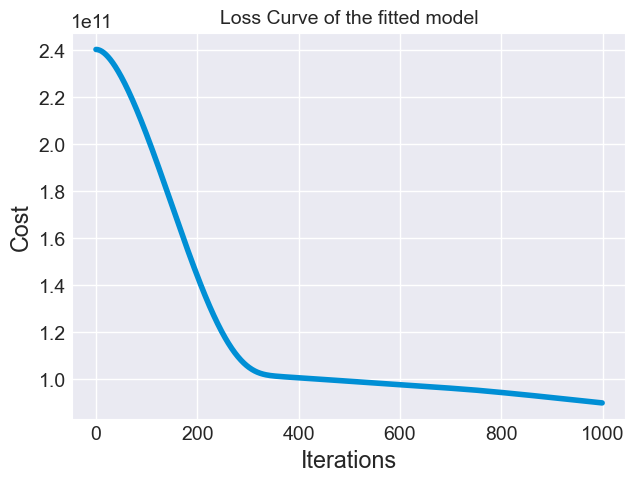

In [139]:
#Loss Curve fitting the model

plt.plot(best.loss_curve_)
plt.title("Loss Curve of the fitted model", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

In [140]:
# Model training error
#-------------------------------------------------------------------------------
prediction_train = best.predict(X = datos_train_prep)

#Measuring Goodness of fit in Training data

# Print R_squared and RMSE value
#

print('R2 Value in training:', round(metrics.r2_score(y_train, prediction_train),2))


#Measuring accuracy on Testing Data
print('Accuracy in training',round( 100- (np.mean(np.abs((y_train - prediction_train) / y_train)) * 100), 2))

train_set_rmse = np.sqrt(mean_squared_error(y_train, prediction_train))
print('RMSE in training: ', round(train_set_rmse,4))

# Residuals     
residuals_train=y_train - prediction_train


R2 Value in training: 0.15
Accuracy in training 50.94
RMSE in training:  423792.2542


<Axes: xlabel='latestPrice', ylabel='Density'>

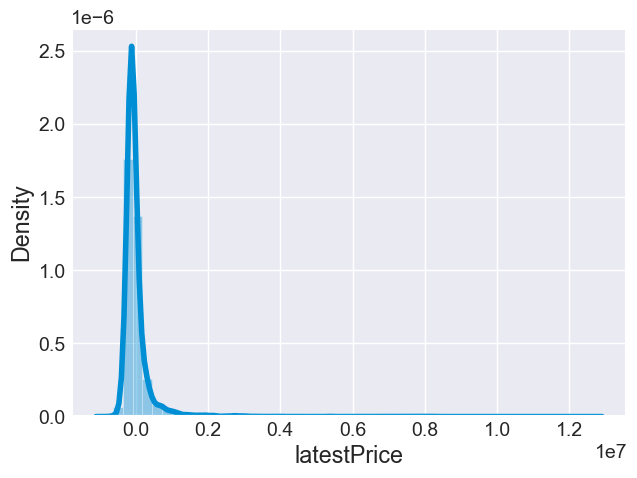

In [141]:
# Error in training
sns.set_style('darkgrid')
sns.distplot(residuals_train)

In [142]:
# Indicators of the model obtained
print('Mean Absolute Error - training:', metrics.mean_absolute_error(y_train, prediction_train))  
print('Mean Squared Error - training:', metrics.mean_squared_error(y_train, prediction_train))  
print('Root Mean Squared Error - training:', np.sqrt(metrics.mean_squared_error(y_train, prediction_train)))

Mean Absolute Error - training: 204634.56038292378
Mean Squared Error - training: 179599874728.58917
Root Mean Squared Error - training: 423792.2542102311


In [143]:
# Model test error
#-------------------------------------------------------------------------------
prediction_test = best.predict(X = datos_test_prep)

#Measuring Goodness of fit in Training data

# Print R_squared and RMSE value
#

print('R2 Value in test:', round(metrics.r2_score(y_test, prediction_test),2))

#Measuring accuracy on Testing Data
print('Accuracy in test',round( 100- (np.mean(np.abs((y_test - prediction_test) / y_test)) * 100), 2))

test_set_rmse = np.sqrt(mean_squared_error(y_test, prediction_test))
print('RMSE in test: ', round(test_set_rmse,4))

# Residuals    
residuals_test=y_test - prediction_test

R2 Value in test: 0.2
Accuracy in test 41.62
RMSE in test:  351948.5022


<Axes: xlabel='latestPrice', ylabel='Density'>

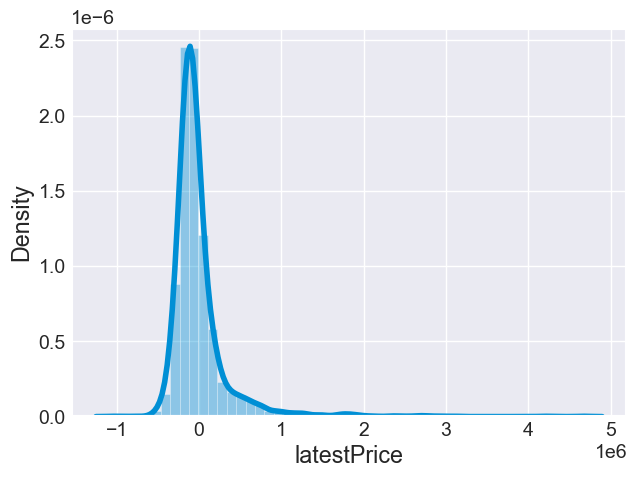

In [144]:
# Error in test
sns.set_style('darkgrid')
sns.distplot(residuals_test)

In [145]:
# Indicators of the model with test
print('Mean Absolute Error - test:', metrics.mean_absolute_error(y_test, prediction_test))  
print('Mean Absolute Error - test:', metrics.mean_absolute_error(y_test, prediction_test))  
print('Mean Squared Error - test:', metrics.mean_squared_error(y_test, prediction_test))  
print('Root Mean Squared Error - test:', np.sqrt(metrics.mean_squared_error(y_test, prediction_test)))

Mean Absolute Error - test: 200968.97139943583
Mean Absolute Error - test: 200968.97139943583
Mean Squared Error - test: 123867748174.45302
Root Mean Squared Error - test: 351948.5021625366


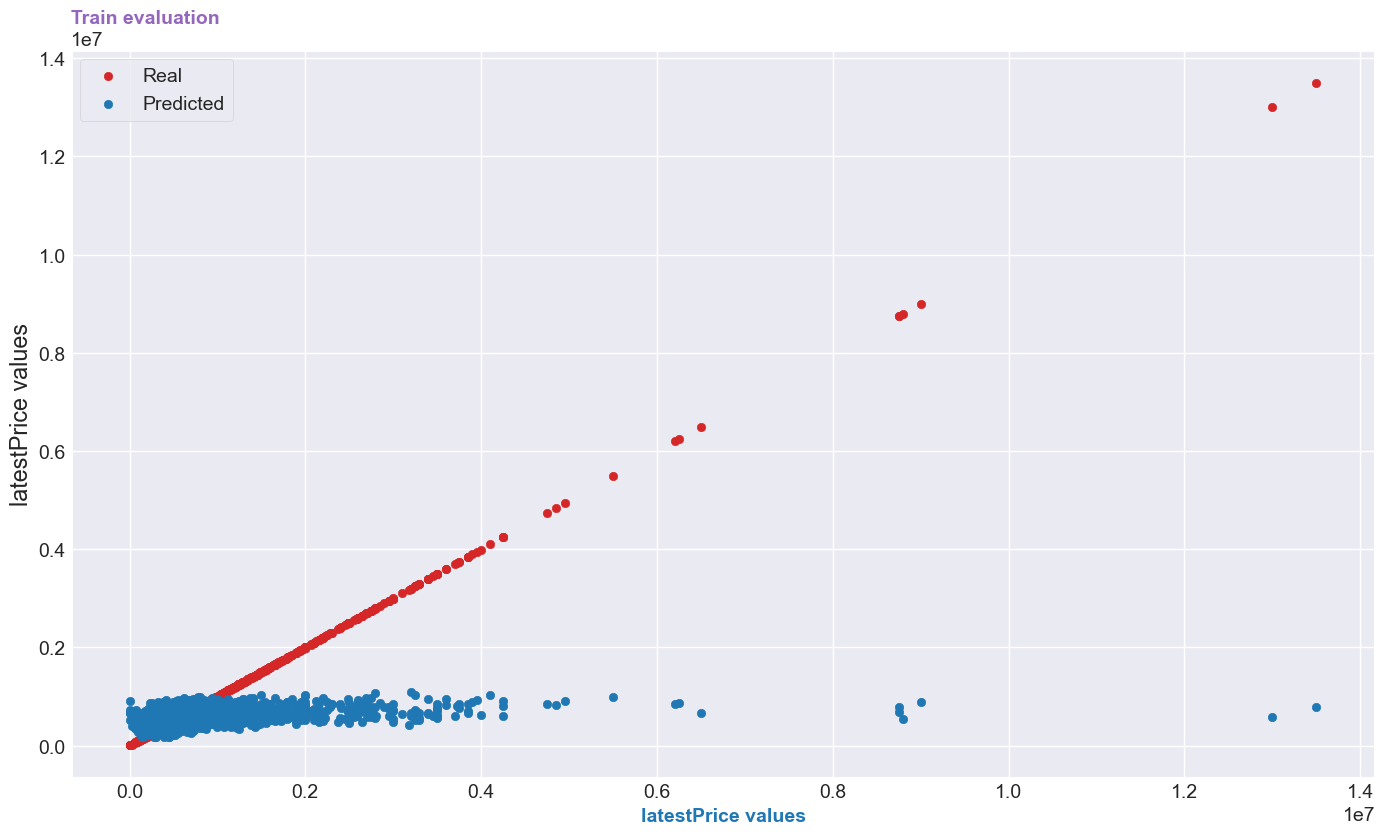

In [146]:
# TRAINING Real vs Predicted values
import matplotlib.pyplot as plt  # TRAINING

fig, ax = plt.subplots(figsize=(15, 9))


#x_axis=list(range(len(y_train)))

ax.scatter(y_train, y_train, color = 'tab:red', label='Real')
ax.scatter(y_train, prediction_train, color = 'tab:blue', label='Predicted')
ax.set_xlabel("latestPrice values", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("latestPrice values")
ax.set_title('Train evaluation', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

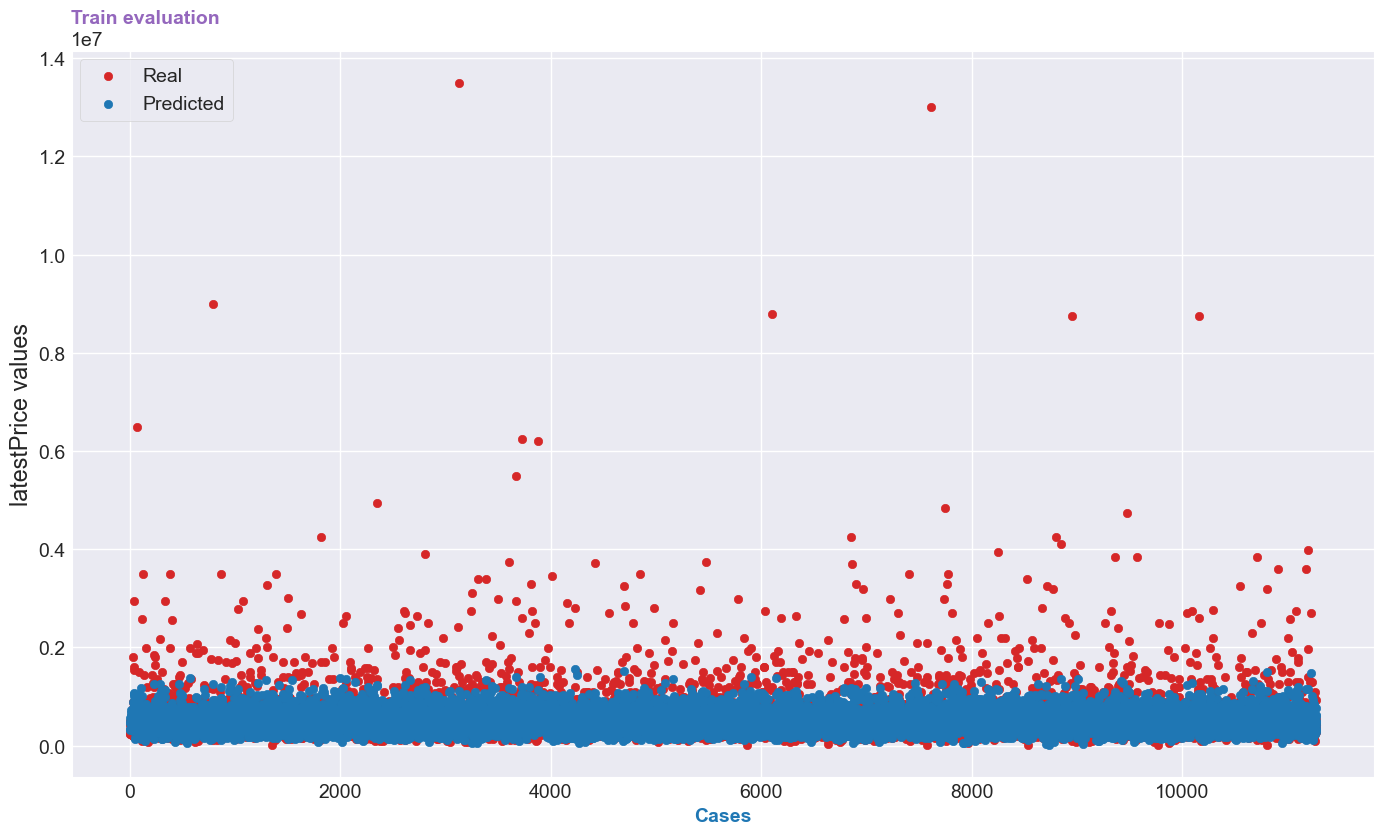

In [133]:
# TRAINING Real vs Predicted values
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 9))


x_axis=list(range(len(y_train)))

ax.scatter(x_axis, y_train, color = 'tab:red', label='Real')
ax.scatter(x_axis, prediction_train, color = 'tab:blue', label='Predicted')
ax.set_xlabel("Cases", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("latestPrice values")
ax.set_title('Train evaluation', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

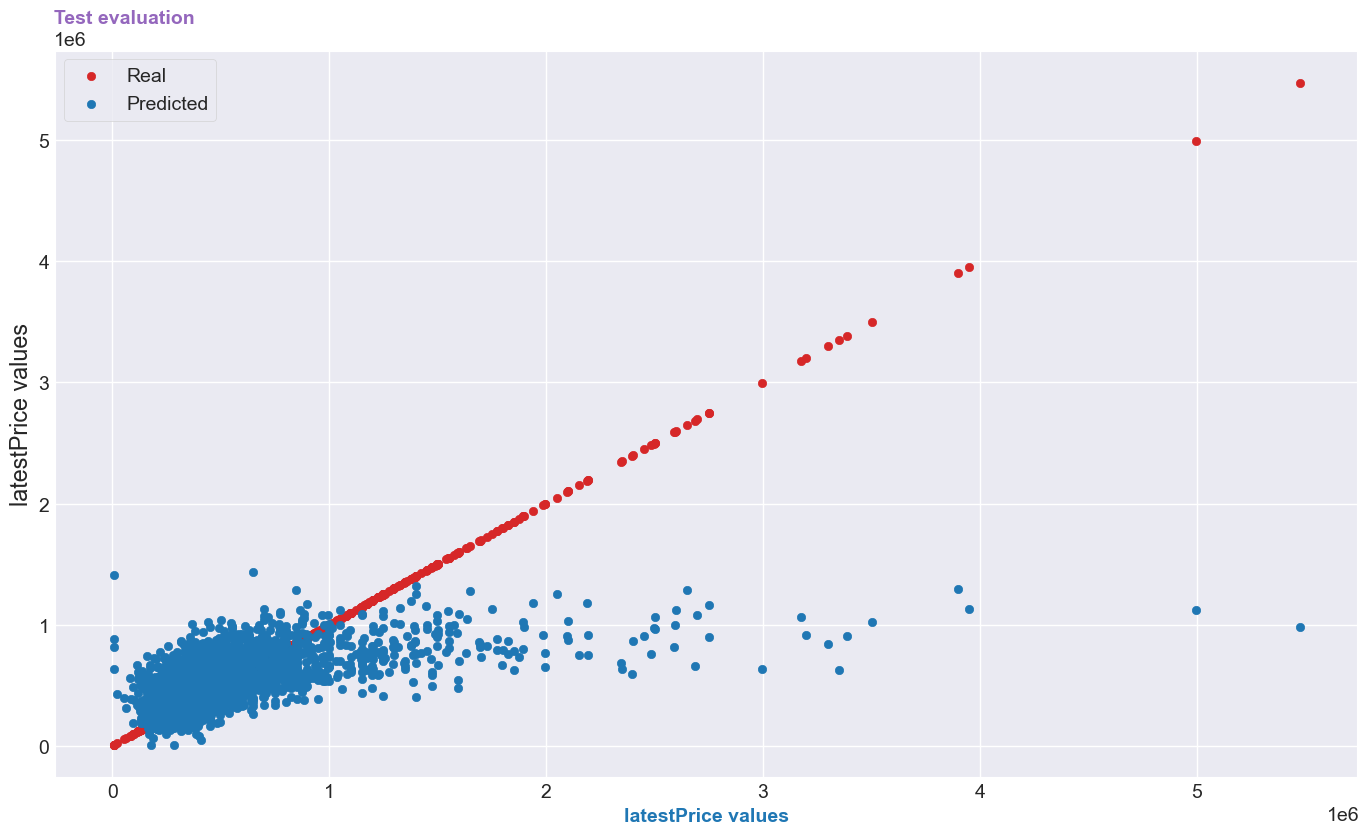

In [134]:
#######  TEST

fig, ax = plt.subplots(figsize=(15, 9))


#x_axis=list(range(len(y_train)))

ax.scatter(y_test, y_test, color = 'tab:red', label='Real')
ax.scatter(y_test, prediction_test, color = 'tab:blue', label='Predicted')
ax.set_xlabel("latestPrice values", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("latestPrice values")
ax.set_title('Test evaluation', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()

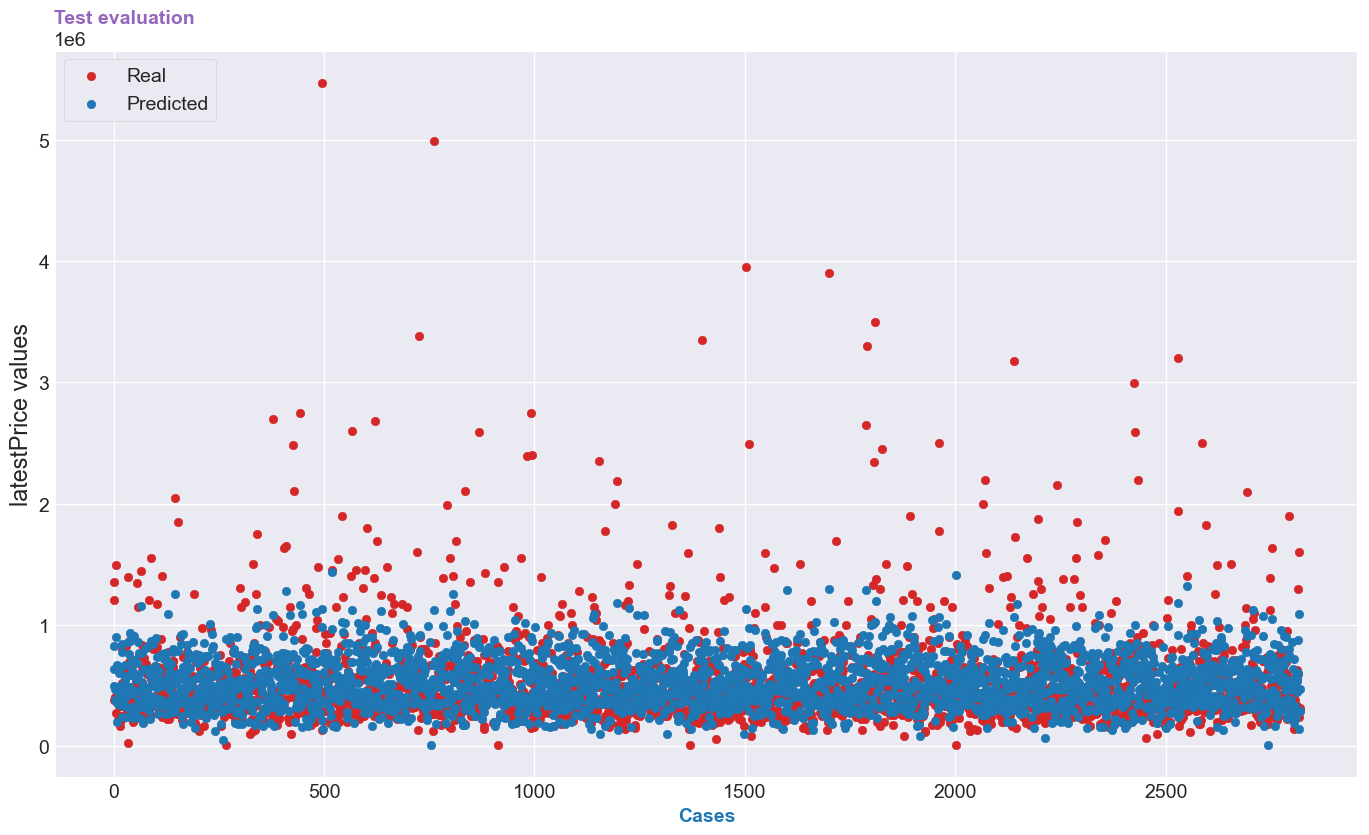

In [135]:
# TEST Real vs Predicted values

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 9))


x_axis=list(range(len(y_test)))

ax.scatter(x_axis, y_test, color = 'tab:red', label='Real')
ax.scatter(x_axis, prediction_test, color = 'tab:blue', label='Predicted')
ax.set_xlabel("Cases", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_ylabel("latestPrice values")
ax.set_title('Test evaluation', loc = "left", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:purple'})
ax.legend(loc = 'upper left')
plt.show()